In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from torch.optim import Adam

import pyreadr
import seaborn as sns

from core.jmstate import JointModel
from core.utils import Fun

In [2]:
data = pyreadr.read_r("data/data.RData") # Read .rdata file
print(data.keys())
df_long = data['data_long']
df_surv = data['data_surv']

odict_keys(['data_long', 'data_surv'])


In [3]:
df_long_pivot = df_long.pivot(index='id', columns='times', values='Y')
df_X = df_long[['id', 'X']].drop_duplicates()
df_long_final = pd.merge(df_X, df_long_pivot, on='id', how='left')
df_long_final.head()

,id,X,0.0,0.333,0.666,0.999,1.332,1.665,1.998,2.331,...,13.32,13.653,13.986,14.319,14.652,14.985,15.318,15.651,15.984,16.317
0,1.0,1.358953,1.402764,0.938133,0.786028,-0.034032,0.435265,-0.374447,-1.053485,-0.596061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.833495,0.457030,-0.133761,-0.394960,-0.410892,-0.696742,-0.132951,0.145854,0.020514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2.224321,0.687617,0.148281,-0.066805,-0.392109,-0.241041,-0.449122,0.180463,-0.301997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,1.224121,1.184289,0.199906,-0.367288,-1.025969,-0.812802,-1.393619,-1.409206,-1.118797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,2.179657,1.814391,1.058987,0.055875,-0.071036,-0.227429,-0.466335,-0.822670,-0.748077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


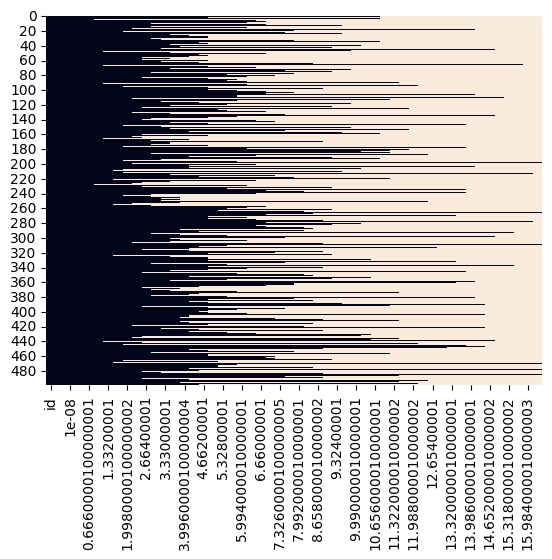

In [4]:
sns.heatmap(df_long_final.isnull(), cbar=False)
plt.show()

In [5]:
df_surv_final = df_surv.drop(columns='X').reset_index(drop=True)
df_surv_final.head(n=20)

,id,t_State_1,State_1,t_State_2,State_2
0,1.0,10.756110,0.0,10.756110,1.0
1,2.0,3.064827,0.0,3.064827,1.0
2,3.0,4.742421,0.0,4.742421,0.0
3,4.0,10.929748,0.0,10.929748,0.0
4,5.0,10.957797,0.0,10.957797,0.0
5,6.0,0.900404,1.0,8.300900,0.0
6,7.0,6.566841,0.0,6.566841,1.0
7,8.0,6.923897,1.0,13.589899,1.0
8,9.0,4.384291,0.0,4.384291,0.0
9,10.0,6.054999,1.0,12.551436,0.0


In [6]:
X = df_long_final['X'].values.reshape(-1, 1)
t = np.array(df_long_final.columns[2:].values, dtype=np.float32)
Y = df_long_final.drop(columns=['id', 'X']).values[:, :, None]
T_raw = df_surv_final
T = [[(0.0, 0)]
     + ([(float(df_surv_final.iloc[i]['t_State_1']), 1)] if df_surv.iloc[i]['State_1'] else [])
     + ([(float(df_surv_final.iloc[i]['t_State_2']), 2)] if df_surv.iloc[i]['State_2'] else [])
     for i in range(len(df_surv_final))
]
C = [float(np.max(t))] * len(df_long_final)

In [7]:
idx_train = np.random.choice(np.arange(len(X)), size=int(len(X) * 1), replace=False)
idx_test = np.setdiff1d(np.arange(len(X)), idx_train)

idx_train = [int(c) for c in idx_train]
idx_test = [int(c) for c in idx_test]

X_train, X_test = X[idx_train], X[idx_test]
Y_train, Y_test = Y[idx_train], Y[idx_test]
T_train, T_test = [T[c] for c in idx_train], [T[c] for c in idx_test]
C_train, C_test = [C[c] for c in idx_train], [C[c] for c in idx_test]

In [8]:
T01 = np.array([df_surv_final.iloc[i]['t_State_1'] for i in range(len(df_surv_final)) if df_surv_final.iloc[i]['State_1'] and i in idx_train])
T02 = np.array([df_surv_final.iloc[i]['t_State_2'] for i in range(len(df_surv_final)) if df_surv_final.iloc[i]['State_2'] and i in idx_train])
T12 = np.array([df_surv_final.iloc[i]['t_State_2'] - df_surv_final.iloc[i]['t_State_1'] for i in range(len(df_surv_final)) if df_surv_final.iloc[i]['State_1'] and df_surv_final.iloc[i]['State_2'] and i in idx_train])

In [9]:
from lifelines import WeibullFitter
from lifelines.utils import median_survival_times

# Assuming T01, T02, T12 are NumPy arrays as defined in your previous code

# Create lifelines-compatible DataFrames
df_T01 = pd.DataFrame({'T': T01, 'E': np.ones(len(T01))})  # E is event indicator (1 for observed event)
df_T02 = pd.DataFrame({'T': T02, 'E': np.ones(len(T02))})
df_T12 = pd.DataFrame({'T': T12, 'E': np.ones(len(T12))})

# Fit Weibull models
wb_T01 = WeibullFitter().fit(df_T01['T'], df_T01['E'])
wb_T02 = WeibullFitter().fit(df_T02['T'], df_T02['E'])
wb_T12 = WeibullFitter().fit(df_T12['T'], df_T12['E'])

# Access parameters directly
lambda_T01 = wb_T01.lambda_  # Scale parameter
rho_T01 = wb_T01.rho_       # Shape parameter

lambda_T02 = wb_T02.lambda_
rho_T02 = wb_T02.rho_

lambda_T12 = wb_T12.lambda_
rho_T12 = wb_T12.rho_

print("\nBase Hazard Parameters:")
print(f"T01: lambda_ = {lambda_T01}, rho = {rho_T01}")
print(f"T02: lambda_ = {lambda_T02}, rho = {rho_T02}")
print(f"T12: lambda_ = {lambda_T12}, rho = {rho_T12}")


Base Hazard Parameters:
T01: lambda_ = 6.335892481192901, rho = 1.909366627827557
T02: lambda_ = 10.244190570369856, rho = 2.1623235907469036
T12: lambda_ = 5.700891489358726, rho = 1.484804453708993


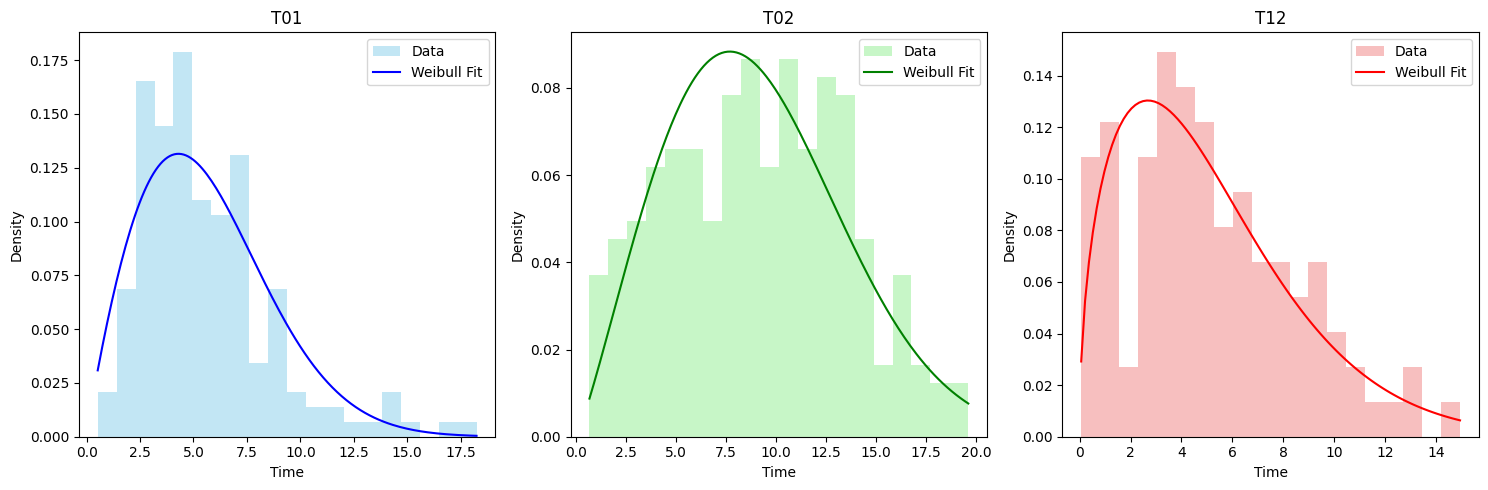

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot for T01
axes[0].hist(T01, bins=20, density=True, alpha=0.5, color='skyblue', label='Data')
axes[0].plot(wb_T01.density_.index, wb_T01.density_.values, color='blue', label='Weibull Fit')
axes[0].set_title('T01')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot for T02
axes[1].hist(T02, bins=20, density=True, alpha=0.5, color='lightgreen', label='Data')
axes[1].plot(wb_T02.density_.index, wb_T02.density_.values, color='green', label='Weibull Fit')
axes[1].set_title('T02')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Density')
axes[1].legend()

# Plot for T12
axes[2].hist(T12, bins=20, density=True, alpha=0.5, color='lightcoral', label='Data')
axes[2].plot(wb_T12.density_.index, wb_T12.density_.values, color='red', label='Weibull Fit')
axes[2].set_title('T12')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()

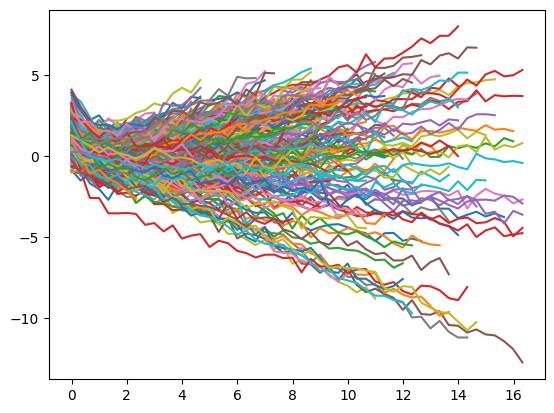

In [11]:
plt.plot(t, Y_train[:, :, 0].T)
plt.show()

In [12]:
# ------------------------------------------------------------
# 1.  Log-Weibull (factory that pre-computes constants)
# ------------------------------------------------------------

def make_log_weibull(lambda_, rho_, *, eps=1e-8, dtype=torch.float32):
    """
    Returns a fast log-Weibull function that closes over pre-computed constants.
    Works entirely on CPU with eager PyTorch.
    """
    lambda_tensor = torch.as_tensor(lambda_, dtype=dtype)
    rho_tensor    = torch.as_tensor(rho_,     dtype=dtype)

    log_prefactor   = torch.log(rho_tensor) - torch.log(lambda_tensor)  # log(rho / lambda)
    rho_minus_one   = rho_tensor - 1.0
    log_lambda      = torch.log(lambda_tensor)

    def _log_weibull(t1: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        tau = (t1 - t0).clamp_min(eps)                # avoids allocation compared to t + eps
        return log_prefactor + rho_minus_one * (torch.log(tau) - log_lambda)

    return _log_weibull


# ------------------------------------------------------------
# 2.  Double-slope link and its gradient
# ------------------------------------------------------------

def double_slope(t: torch.Tensor, x: torch.Tensor, psi: torch.Tensor) -> torch.Tensor:
    """
    corr = (b2 - b1) * relu(t - x0)
    Only one unsqueeze at the end.
    """
    x0, a, b1, b2 = (psi[:, i:i+1] for i in range(4))   # keeps shape (N, 1)
    corr = (b2 - b1) * (t - x0).clamp_min(0.0)
    return (a + b1 * t + corr).unsqueeze(-1)


def double_slope_grad(t: torch.Tensor, x: torch.Tensor, psi: torch.Tensor) -> torch.Tensor:
    """
    Gradient of the double-slope link.
    Avoids torch.where by using a boolean mask.
    """
    x0  = psi[:, [0]]
    b1  = psi[:, [2]]
    b2  = psi[:, [3]]
    grad = b1 + (b2 - b1) * (t > x0).to(t.dtype)
    return grad.unsqueeze(-1)


def link(t: torch.Tensor, x: torch.Tensor, psi: torch.Tensor) -> torch.Tensor:
    """
    Concatenates value and gradient.
    """
    return torch.cat((double_slope(t, x, psi),
                      double_slope_grad(t, x, psi)), dim=-1)


# ------------------------------------------------------------
# 3.  Simple algebraic helper
# ------------------------------------------------------------

f = lambda gamma, b: gamma + b     # unchanged


# ------------------------------------------------------------
# 4.  Wrap everything with your Fun abstraction
# ------------------------------------------------------------

log_weibull_T01 = Fun(make_log_weibull(lambda_T01, rho_T01), (1, 1), 1)
log_weibull_T02 = Fun(make_log_weibull(lambda_T02, rho_T02), (1, 1), 1)
log_weibull_T12 = Fun(make_log_weibull(lambda_T12, rho_T12), (1, 1), 1)

double_slope      = Fun(double_slope,      (1, 1, 4), 1)
double_slope_grad = Fun(double_slope_grad, (1, 1, 4), 1)
link              = Fun(link,              (1, 1, 4), 2)
f                 = Fun(f,                 (4, 4),    4)

In [13]:
surv = {
    (0, 1): {"log_lambda0":log_weibull_T01, "g":link},
    (0, 2): {"log_lambda0":log_weibull_T02, "g":link},
    (1, 2): {"log_lambda0":log_weibull_T12, "g":link},
}

In [14]:
history = []
optimizer = torch.optim.Adam
lr = 1e-2
callback = lambda : history.append([v.detach().clone() for v in joint.params.values() if not isinstance(v, dict)] + [*[v.detach().clone() for v in joint.params["alpha"].values()], *[v.detach().clone() for v in joint.params["beta"].values()]])
joint = JointModel(double_slope, f, surv)
joint.fit(X_train, t, Y_train, T_train, C_train, optimizer=optimizer, optimizer_params={'lr': lr}, n_iter=3000, batch_size=1, callback=callback)

Computing Fisher Information Matrix: 100%|██████████| 1000/1000 [00:27<00:00, 36.47it/s]


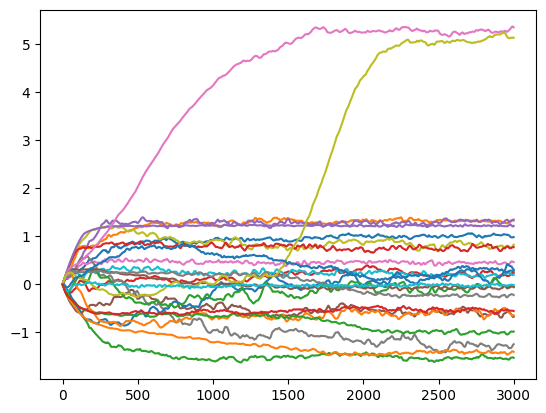

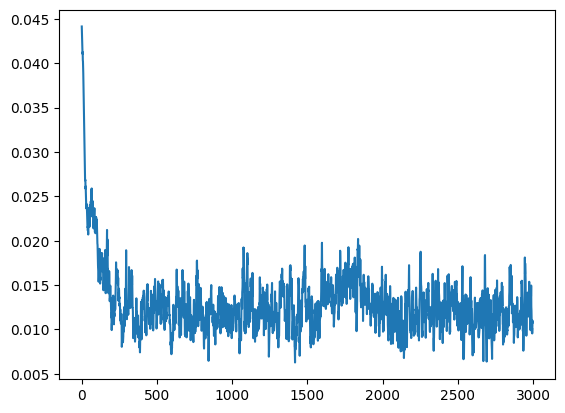

{'gamma': tensor([ 0.9838,  1.3279, -1.5308,  0.2388], requires_grad=True), 'Q_inv': tensor([ 1.3470, -0.6759,  0.4615, -1.2490,  0.8259,  0.1975,  0.3051, -0.6472,
        -0.0485,  0.7741], requires_grad=True), 'R_inv': tensor([1.2143], requires_grad=True), 'alpha': {(0, 1): tensor([-0.0612,  5.3541], requires_grad=True), (0, 2): tensor([-0.2246,  5.1384], requires_grad=True), (1, 2): tensor([-0.0156,  0.2740], requires_grad=True)}, 'beta': {(0, 1): tensor([-1.4092], requires_grad=True), (0, 2): tensor([-0.9859], requires_grad=True), (1, 2): tensor([-0.5586], requires_grad=True)}}


In [15]:
history_vstack = np.vstack([np.hstack([p.numpy().reshape(1, -1) for p in elt]) for elt in history])
plt.plot(np.arange(history_vstack.shape[0]), history_vstack)
plt.show()

plt.plot(np.arange(history_vstack.shape[0] - 1), np.linalg.norm(np.diff(history_vstack, axis=0), axis=1))
plt.show()

print(joint.params)

tensor([[ 1.1653e-01, -1.1846e-02,  1.5715e-01,  3.4791e-04],
        [-1.1846e-02,  6.1183e-01, -3.4744e-01,  8.2336e-02],
        [ 1.5715e-01, -3.4744e-01,  6.7397e-01,  8.4598e-03],
        [ 3.4791e-04,  8.2336e-02,  8.4598e-03,  2.1261e-01]])


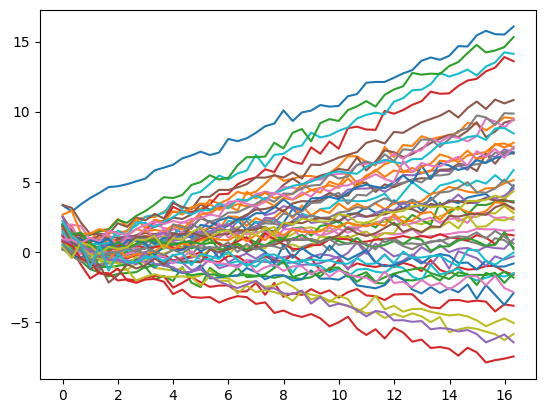

{'gamma': tensor([0.0070, 0.0181, 0.0174, 0.0031]),
 'Q_inv': tensor([0.0671, 0.1502, 0.0733, 0.1609, 0.1593, 0.0808, 0.2184, 0.2630, 0.2260,
         0.0829]),
 'R_inv': tensor([0.0195]),
 'alpha': {(0, 1): tensor([0.0794, 0.4145]),
  (0, 2): tensor([0.1345, 0.5911]),
  (1, 2): tensor([0.0658, 0.0223])},
 'beta': {(0, 1): tensor([0.1293]),
  (0, 2): tensor([0.1126]),
  (1, 2): tensor([0.1812])}}

In [16]:
from core.utils import _tril_from_flat

Q = _tril_from_flat(joint.params["Q_inv"], 4).detach()
Q.view(-1)[::5] = torch.exp(Q.view(-1)[::5])
Q = torch.linalg.inv(Q @ Q.T)

print(Q)

R = _tril_from_flat(joint.params["R_inv"], 1).detach()
R.view(-1)[::2] = torch.exp(R.view(-1)[::2])
R = torch.linalg.inv(R @ R.T)

from scipy.linalg import sqrtm

n = 50

b_sim = torch.randn(n, joint.params["gamma"].detach().shape[0]) @ torch.tensor(sqrtm(Q.numpy()))
psi_sim = f(joint.params["gamma"], b_sim)

Y_sim = joint.h(torch.tensor(t), None, psi_sim)
Y_sim += torch.randn_like(Y_sim) @ torch.tensor(sqrtm(R.numpy()))
plt.plot(t, Y_sim.squeeze(-1).T.detach().numpy())
plt.show()

joint.stderror()

In [17]:
T_init = [[(0.0, 0)] for _ in range(n)]
C_init = [0.0 for _ in range(n)]
C_max = C
T_sim = joint.sample(T_init, C, np.random.randn(n).reshape(-1, 1), psi_sim)
print(T_sim)

[[(0.0, 0), (8.354694366455078, 1), (16.316999435424805, 2)], [(0.0, 0), (0.3326341509819031, 1), (0.8136090040206909, 2)], [(0.0, 0), (1.222729206085205, 1), (9.467734336853027, 2)], [(0.0, 0), (0.9976534247398376, 1), (3.5051398277282715, 2)], [(0.0, 0), (1.5981875658035278, 1), (8.835641860961914, 2)], [(0.0, 0), (4.853818893432617, 2)], [(0.0, 0), (1.1475379467010498, 1), (1.2989177703857422, 2)], [(0.0, 0), (4.37827205657959, 2)], [(0.0, 0), (1.9890823364257812, 1), (3.633592128753662, 2)], [(0.0, 0), (2.374997615814209, 2)], [(0.0, 0), (0.4192783534526825, 1), (1.824059009552002, 2)], [(0.0, 0), (8.44855785369873, 1), (9.645225524902344, 2)], [(0.0, 0), (1.5541185140609741, 1), (3.8916800022125244, 2)], [(0.0, 0), (16.316999435424805, 1)], [(0.0, 0), (1.3865563869476318, 2)], [(0.0, 0), (1.242896318435669, 1), (1.974796175956726, 2)], [(0.0, 0), (5.963014602661133, 1), (13.068424224853516, 2)], [(0.0, 0), (12.042301177978516, 2)], [(0.0, 0), (6.869293212890625, 1), (9.21334457397